# TP4 - Agents

Dans ce notebook on s'intéresse à la méthodologie agent en utilisant le framework technique LangChain. Notre application sera l'api de la World Bank Data qui est une source de données à l'échelle mondiale sur l'état, d'un point de vue statistique, d'un pays.
La difficulté de cette API est qu'elle est très riche, avec des indicateurs ayant des codes complexes. De plus, les codes des pays sont spécifiques, la manière de requêter est précise.

Pour exploiter du mieux possible les données disponibles, on se propose de définir un agent dont le rôle est de traiter une questions posées en langage naturel et requêter puis analyser les résultats.

## Trouver le bon indicateur

On commence par le premier enjeu : traduire une question en une liste d'indicateurs potentiel permettant d'aider à répondre. Pour ce faire, nous avons récupérer l'ensemble des indicateurs disponible et la descriptions associées.

In [1]:
import pandas as pd

def build_embedding_text(row: pd.Series) -> str:
    answer = f"""Indicator code: {row['indicator']}\nIndicator description: {row['description']}\nIndicator source name: {row['source_name']}"""
    return answer

df_indicators = pd.read_csv('WBData_indicators.csv')

df_indicators["embedding_text"] = df_indicators.apply(build_embedding_text, axis=1)
df_indicators.head()

,indicator,description,source,source_name,index,embedding_text
0,1.0.HCount.1.90usd,Poverty Headcount ($1.90 a day),topics,Poverty,11,Indicator code: 1.0.HCount.1.90usd\nIndicator ...
1,1.0.HCount.2.5usd,Poverty Headcount ($2.50 a day),topics,Poverty,11,Indicator code: 1.0.HCount.2.5usd\nIndicator d...
2,1.0.HCount.Mid10to50,Middle Class ($10-50 a day) Headcount,topics,Poverty,11,Indicator code: 1.0.HCount.Mid10to50\nIndicato...
3,1.0.HCount.Ofcl,Official Moderate Poverty Rate-National,topics,Poverty,11,Indicator code: 1.0.HCount.Ofcl\nIndicator des...
4,1.0.HCount.Poor4uds,Poverty Headcount ($4 a day),topics,Poverty,11,Indicator code: 1.0.HCount.Poor4uds\nIndicator...


Nous allons construire un embedding de la colonne *embedding_text* pour pouvoir dans un second temps la requêter avec la méthoode FAISS.

**Consigne** : En exploitant les fonctions `build_faiss_index` et `retrieve_index` dans le module `rag_utils`, constuire l'embedding et le tester sur question.

In [2]:
from rag_utils import build_faiss_index, retrieve_index

index_indicators = build_faiss_index(df_indicators["embedding_text"].to_list())
print(f"FAISS index contains {index_indicators.ntotal} vectors")

question = "What is the inflation value in Senegal ? ?"
results = retrieve_index(dataframe=df_indicators, query=question, index=index_indicators, k=10)
results

Batches:   0%|          | 0/409 [00:00<?, ?it/s]

FAISS index contains 26142 vectors


,indicator,description,source,source_name,index,embedding_text,score
6313,FR.INR.MMKT,Money market rate (%),sources,Africa Development Indicators,11,Indicator code: FR.INR.MMKT\nIndicator descrip...,0.506723
6271,FM.LBL.MQMY.GD.ZS,Money and quasi money (M2) as % of GDP,sources,Africa Development Indicators,11,Indicator code: FM.LBL.MQMY.GD.ZS\nIndicator d...,0.476443
9990,PE.NUS.FCAE,"Official exchange rate (LCU per US$, end period)",sources,Africa Development Indicators,11,Indicator code: PE.NUS.FCAE\nIndicator descrip...,0.467072
6307,FR.INR.IMPL,"International interest rate, implicit (%)",sources,Africa Development Indicators,11,Indicator code: FR.INR.IMPL\nIndicator descrip...,0.462952
6299,FP.CPI.TOTL.ZG,"Inflation, consumer prices (annual %)",topics,Economy & Growth,3,Indicator code: FP.CPI.TOTL.ZG\nIndicator desc...,0.452433
9781,NY.GDP.DEFL.KD.ZG,"Inflation, GDP deflator (annual %)",topics,Economy & Growth,3,Indicator code: NY.GDP.DEFL.KD.ZG\nIndicator d...,0.436230
1004,AG.CRP.FNO.CN,"Producer Price for Fonio (per tonne, current LCU)",sources,Africa Development Indicators,11,Indicator code: AG.CRP.FNO.CN\nIndicator descr...,0.433375
6268,FM.LBL.MONY.CN,Money (current LCU),sources,Africa Development Indicators,11,Indicator code: FM.LBL.MONY.CN\nIndicator desc...,0.430657
9798,NY.GDP.MKTP.CD.XD,"GDP deflator, index (2000=100; US$ series)",sources,Africa Development Indicators,11,Indicator code: NY.GDP.MKTP.CD.XD\nIndicator d...,0.419506
1003,AG.CRP.FNO.CD,"Producer Price for Fonio (per tonne, current US$)",sources,Africa Development Indicators,11,Indicator code: AG.CRP.FNO.CD\nIndicator descr...,0.418065


Il faut maintenant constuire une fonction pour que ça soit un outil de notre agent.

**Consigne** : Construire une fonction `retrieve_indicators` qui à partir d'une question et d'un nombre d'indicateurs à renvoyer, renvoie les indicateurs les plus pertinents (selon l'embedding) pour la question.
Dans un soucis de simplicité, on ne renverras que trois colonnes : l'indicateur, sa description et le score associé.

In [3]:
def retrieve_indicators(query: str, k: int=10):
    results = retrieve_index(dataframe=df_indicators, query=query, index=index_indicators, k=k)
    return results[["indicator", "description", "score"]].reset_index(drop=True)

Nous sommes maintenant capables d'identifier des indicateurs pertinent pour une question donnée. Il faut maintenant obtenir les codes des pays qui nous intéresse.

## Identifier les codes de pays

De la même manière que précédemment, nous avons l'ensemble des valeurs disponibles.

In [29]:
countries = pd.read_csv("WBData_countries.csv")
countries["embedding_text"] = countries.apply(lambda row: f"""Code: {row["Code"]}\nDescription: {row["Description"]}""", axis=1)
countries.head()

,Code,Description,embedding_text
0,ABW,Aruba,Code: ABW\nDescription: Aruba
1,AFE,Africa Eastern and Southern,Code: AFE\nDescription: Africa Eastern and Sou...
2,AFG,Afghanistan,Code: AFG\nDescription: Afghanistan
3,AFR,Africa,Code: AFR\nDescription: Africa
4,AFW,Africa Western and Central,Code: AFW\nDescription: Africa Western and Cen...


**Consigne** : reproduire *mutatis mutandis* le travail précédent dans le cadre des codes de pays.

In [5]:
index_countries = build_faiss_index(countries["embedding_text"].to_list())
print(f"FAISS index contains {index_countries.ntotal} vectors")

def retrieve_countries(query: str, k: int=10):
    results = retrieve_index(dataframe=countries, query=query, index=index_countries, k=k)
    return results[["Code", "Description", "score"]].reset_index(drop=True)

Batches:   0%|          | 0/5 [00:00<?, ?it/s]

FAISS index contains 296 vectors


A présent nous avons deux fonctions : une pour indentifier les indicateurs pertinent, une pour identifier les codes pays d'intérêts.

## Appeler correctement l'API

L'objectif est à présent de requêter l'API correctement. Par exemple pour l'inflation annuelle en pourcentage, vue par le consommateur, en France entre 2015 et 2020, la requête est :

In [6]:
import wbdata

code = "FP.CPI.TOTL.ZG"
country = "FRA"
series = wbdata.get_series(code, date=("2015", "2020"), country=[country])
series

date
2020    0.476499
2019    1.108255
2018    1.850815
2017    1.032283
2016    0.183335
2015    0.037514
Name: value, dtype: float64

Si on souhaite l'obtenir pour la France et l'Allemagne :

In [ ]:
code = "FP.CPI.TOTL.ZG"
country = ["FRA", "DEU"]
series = wbdata.get_series(code, date=("2015", "2020"), country=country)
series

country  date
Germany  2020    0.144878
         2019    1.445660
         2018    1.732169
         2017    1.509495
         2016    0.491747
         2015    0.514426
France   2020    0.476499
         2019    1.108255
         2018    1.850815
         2017    1.032283
         2016    0.183335
         2015    0.037514
Name: value, dtype: float64

**Consigne** : Compléter la fonction `query_api` dont l'objectif est de requêter l'API World Bank Data. A partir d'un code d'indicateur, d'une période en années et d'un code de pays, retourner un DataFrame simple de lecture.

In [8]:
def query_api(code: str, date: [str, str], country: str):
    print(f"Query API : {code}\t{date}\t{country}")
    series = wbdata.get_series(code, date=date, country=country)

    if type(country) == str:
        data = pd.DataFrame({"year": series.index.values, country: series.values})

    else:
        countries = list(set([field[0] for field in series.index]))
        data = pd.DataFrame({"year": series.get(countries[0]).index.values})
        for country in countries: data[country] = series.get(country).values
        
    return data

## Agent ! 

Passons maintenant à l'étape de conception de l'agent, nous utiliserons LangGraph pour le faire.

Pour commencer, faisons le récapitulatif des fonctions que nous avons construites :
1. `retrieve_indicators` : récupérer les codes pertinents pour une question donnée
2. `retrieve_countries` : récupérer les codes pays pertinents pour une question donnée
3. `query_api` : requêter proprement l'API d'intérêt

In [9]:
TOOL_REGISTRY = {
    "retrieve_indicators": retrieve_indicators,
    "retrieve_countries": retrieve_countries,
    "query_api": query_api
}

### Structure de l'agent

Dans LangGraph, un agent est un graphe d'actions et d'informations évolutifs. Nous allons définir :
1. Une **classe** qui représentera l'agent. L'objectif est de pouvoir stocker et utiliser par la suite à bon essient les avancées de l'agent.
2. Des **méthodes** qui sont les sommets dans le graphes d'actions de l'agent. Ces méthodes exploitent les informations contenues dans la classe.
3. Un **graphe** qui va permettre de définir comment passer d'un sommet à l'autre.

Commençons par la classe. Nous appelons l'agent à partir d'une **question** sur laquelle il va **réfléchir** et élaborer un plan d'action qui ici se résumé à des **appels** aux fonctions que nous avons définies. Puis, exploitant les **résultats** de ces appels, l'agent pourra **requêter** l'API puis **analyser** le résultat, à la lumière de la question posée initialement.

Nous allons exactement coder cela, chaque mot en gras correspond à une information que l'on va stocker et exploiter au moment opportun.

In [10]:
from typing import TypedDict, List, Any
from pydantic import BaseModel, Field
from typing import List, Dict, Any


class AgentState(TypedDict):
    question: str
    tool_thoughts: str
    query_thoughts: str
    tool_calls: List[dict]
    tool_results: List[Any]
    query_calls: List[dict]
    query_results: List[dict]
    answer: str

Pour travailler, nous n'utiliserons qu'un seul modèle, ici Gemma3 version 12B. 

In [11]:
from langchain_ollama import OllamaLLM

model = OllamaLLM(model="gemma3:12b")

### Préparation de l'appel

La première étape consiste à préparer l'appel à l'API. Nous avons besoin que le modèle puisse à la fois nous liver sa réflexion et les outils qu'il souhaite exploiter.
Nous allons donc définir notre propre *parser* du résultat du modèle :

1. **Raisonnement** : pour auditer la réflexion du modèle. Ici, simplement du texte suffit.
2. **Outil** : pour savoir quels outils appeler avec quel paramètrage. Ici nous devons définir une liste d'appels.

In [12]:
from langchain.output_parsers import PydanticOutputParser

class ToolCall(BaseModel):
    name: str = Field(description="Name of the tool to call")
    args: Dict[str, Any] = Field(description="Arguments for the tool")

class ReasoningOutput(BaseModel):
    thought: str = Field(description="Short explanation of reasoning")
    tools: List[ToolCall] = Field(description="Tools to call")



parser = PydanticOutputParser(pydantic_object=ReasoningOutput)
format_instructions = parser.get_format_instructions()
print(format_instructions)

The output should be formatted as a JSON instance that conforms to the JSON schema below.

As an example, for the schema {"properties": {"foo": {"title": "Foo", "description": "a list of strings", "type": "array", "items": {"type": "string"}}}, "required": ["foo"]}
the object {"foo": ["bar", "baz"]} is a well-formatted instance of the schema. The object {"properties": {"foo": ["bar", "baz"]}} is not well-formatted.

Here is the output schema:
```
{"$defs": {"ToolCall": {"properties": {"name": {"description": "Name of the tool to call", "title": "Name", "type": "string"}, "args": {"additionalProperties": true, "description": "Arguments for the tool", "title": "Args", "type": "object"}}, "required": ["name", "args"], "title": "ToolCall", "type": "object"}}, "properties": {"thought": {"description": "Short explanation of reasoning", "title": "Thought", "type": "string"}, "tools": {"description": "Tools to call", "items": {"$ref": "#/$defs/ToolCall"}, "title": "Tools", "type": "array"}}, "

Nous avons en plus les instructions à fournir au modèle pour formatter la réponse.

Nous pouvons enfin créer notre premier sommet/noeud du graphe :

In [13]:
def preparation_node(state: AgentState) -> AgentState:
    prompt = f"""
You are a AI agent data analyst using the World Bank Data API to answer the user question. You MUST use the two tools to answer the question.

User question:
{state['question']}

Available tools:
- retrieve_indicators(query: str) : ask a question to see which indicators might help
- retrieve_countries(query: str) : ask a question to retrieve the code of a specific country or a geographic zone



{format_instructions}
"""
    response = model.invoke(prompt)
    decision = parser.parse(response)
    
    state["tool_thoughts"] = decision.thought
    state["tool_calls"] = [
        {"name": tool.name, "args": tool.args} for tool in decision.tools
    ]
    return state


Nous avons appelé le modèle, récupérer sa réponse dans un format facilement exploitable pour nous puis stocké les informations. Il nous faut maintenant concrétement appeler les outils et stocker les résultats : c'est complétement déterministe.

### Appels d'outils

In [14]:
def tool_execution_node(state: AgentState) -> AgentState:
    results = []
    for call in state["tool_calls"]:
        tool_name = call["name"]
        tool_args = call.get("args", {})

        tool_function = TOOL_REGISTRY.get(tool_name)
        if tool_function is None:
            results.append({"tool": tool_name, "args": tool_args, "error": "Unknown tool"})
            continue

        try:
            result = tool_function(**tool_args)
            results.append({"tool": tool_name, "args": tool_args, "result": result})
        except:
            continue

    state["tool_results"] = results
    return state


### Noeuds de requête

Après la préparation et la récupération des informations via les outils que nous avons défini plus tôt, nous pouvons définir un nouveau sommet/noeud dont l'objectif est de définir l'appel à la fonction `query_api`.

**Consigne** En s'inspirant du sommet `preparation_node`, compléter la cellule ci-dessous.

In [15]:
def query_node(state: AgentState) -> AgentState:
    prompt = f"""
You are in a AI agent system. Based on the following informations, use the tool to help answer the user question.

User question:
{state['question']}

Your reasoning:
{state['tool_thoughts']}

Data retrieved from tools:
{state['tool_results']}

Available tool: query_api(code, date, country) with parameters :
    - code : string linked to an indicator in the world bank data. Example : FR.INR.MMKT
    - date : string of the year. If you need to query for a period, use a list with the starting and ending year. Examples : "2025" or ["2020", "2023"]
    - country: string or list of string representing a country with a 3 letter code. Examples : "FRA" or ["UAE", "DEU"]

{format_instructions}
"""
    response = model.invoke(prompt)
    decision = parser.parse(response)

    state["query_thoughts"] = decision.thought
    state["query_calls"] = [
        {"name": tool.name, "args": tool.args} for tool in decision.tools
    ]

    return state

Il reste à exécuter ce que ce sommet/noeud a jugé utile :

In [16]:
def query_execution_node(state: AgentState) -> AgentState:
    results = []
    for call in state["query_calls"]:
        tool_name = call["name"]
        tool_args = call.get("args", {})

        tool_function = TOOL_REGISTRY.get(tool_name)
        if tool_function is None:
            results.append({"tool": tool_name, "args": tool_args, "error": "Unknown tool"})
            continue

        result = tool_function(**tool_args)
        results.append({"tool": tool_name, "args": tool_args, "result": result})

    state["query_results"] = results
    return state


### Synthèse

Après tout ces appels et ces informations collectées, il est temps de les restituer sous forme de simple texte.

In [17]:
def synthesis_node(state: AgentState) -> AgentState:
    prompt = f"""
You are an expert in data analysis and you used the World Bank Data API.

User question:
{state['question']}

Your reasoning:
{state['query_thoughts']}

Data retrieved from tools:
{state['query_results']}

Write a concise and clear answer to the user question, based ONLY on the information you have. Be thoughtful, write in plain text : do not use too much formatting.
"""
    state["answer"] = model.invoke(prompt)
    return state

### Définition du graphe

A ce stade, nous avons des bouts du puzzles mais ils ne sont pas assemblé. C'est ce que nous allons faire maintenant. On commence par ajouter les noeuds/sommets :

In [18]:
from langgraph.graph import StateGraph, END

graph = StateGraph(AgentState)

graph.add_node("preparation", preparation_node)
graph.add_node("preparation_tools", tool_execution_node)

graph.add_node("query", query_node)
graph.add_node("query_tools", query_execution_node)

graph.add_node("synthesis", synthesis_node)

Puis les liens entres les différents noeuds/sommets :

In [19]:
graph.set_entry_point("preparation")
graph.add_edge("preparation", "preparation_tools")
graph.add_edge("preparation_tools", "query")
graph.add_edge("query", "query_tools")
graph.add_edge("query_tools", "synthesis")

agent = graph.compile()

Il est maintenant temps de l'utiliser !

In [20]:
question = "What the evolution of France's inflation between 2015 and 2025 ? Comment on this value using the inflation in Europe, or in Germany for example."

initial_state = {
    "question": question,
    "tool_thoughts": "",
    "query_thoughts": "",
    "tool_calls": [],
    "tool_results": [],
    "query_calls": [],
    "query_results": [],
    "answer": ""
}

result = agent.invoke(initial_state)

Query API : FP.CPI.TOTL.ZG	['2015', '2025']	FRA
Query API : FP.CPI.TOTL.ZG	['2015', '2025']	EUU
Query API : FP.CPI.TOTL.ZG	['2015', '2025']	DEU


On peut obtenir le résultat de l'agent ainsi que ces différentes réflexion tout au long du processus :

In [21]:
print(result["answer"])

Here’s an analysis of France’s inflation between 2015 and 2025, compared to Europe (EUU) and Germany (DEU), based on World Bank data:

**France’s Inflation Evolution:**

France experienced low inflation between 2015 and 2019, ranging from 0.04% in 2015 to 1.11% in 2019. Inflation rose to 1.64% in 2021, then significantly increased in 2022 and 2023, reaching 5.22% and 4.88% respectively.  In 2024, inflation was 1.99%.

**Comparison with Europe and Germany:**

*   **Europe (EUU):**  Europe generally experienced higher inflation rates than France, particularly in 2022 and 2023. European inflation peaked at 8.83% in 2022, significantly higher than France's 5.22% in the same year.
*   **Germany (DEU):** Germany also had higher inflation rates than France during 2022 and 2023, with peaks of 6.87% and 5.95% in those years, respectively.

In summary, while France's inflation has fluctuated, it has generally remained relatively aligned with the European trend, although it was slightly lower tha

C'est pas mal ! Mais nous avons probablement eu de la chance : la requête a été bien formulée. Ce ne sera peut-être pas toujours le cas, nous avons besoin de plus de sécurité.

## Plus de robustesse dans la génération de la requête

On se propose ici d'améliorer cet aspect en modifiant le graphe :
- Ajout d'un module de **validation déterministe** des paramètres de la requête sélectionné
- Ajout d'un noeud/sommet de revus des paramètres s'il y a une erreur, pour le **réparer**

Ces deux ajustements nous demanderons de modifier la classe de définition de l'agent et le graphe.

### Validation déterministe

On commence par la classe `QueryPlan` :

In [52]:
class QueryPlan(BaseModel):
    indicator_code: str = Field(description="World Bank indicator code")
    countries: List[str] = Field(description="List of 3-letter country codes")
    start_year: int = Field(description="Start year of the query")
    end_year: int = Field(description="End year of the query")


**Consigne** : Modifier la classe de l'agent pour remplacer *query_calls* et *query_results* par :
* *query_plan* qui sera un dictionnaire optionnel
* *validation_errors* qui sera une liste de string optionnel, pour aider à débugger

In [53]:
from typing import Optional

class AgentState(TypedDict):
    question: str
    tool_thoughts: str
    tool_calls: List[dict]
    tool_results: List[Any]

    query_thoughts: str
    query_plan: Optional[dict]
    validation_errors: Optional[List[str]]

    query_results: Optional[List[dict]]
    answer: str


Il nous faut modifier la fonction `query_node` pour produire quelque chose de plus simple à valider :

In [ ]:
from langchain.output_parsers import PydanticOutputParser

query_plan_parser = PydanticOutputParser(pydantic_object=QueryPlan)
query_plan_format = query_plan_parser.get_format_instructions()


def query_node(state: AgentState) -> AgentState:
    prompt = f"""
You are an AI agent building a structured query plan for the World Bank Data API.

User question:
{state['question']}

Retrieved indicators and countries:
{state['tool_results']}

Return exactly one query plan with:
- indicator_code
- countries (list)
- start_year
- end_year

{query_plan_format}
"""
    response = model.invoke(prompt)
    plan = query_plan_parser.parse(response)

    state["query_thoughts"] = "Structured query plan generated"
    state["query_plan"] = plan.model_dump()
    return state


Puis il nous faut un module de validation déterministe :

In [55]:
VALID_INDICATORS = set(df_indicators["indicator"].values)
VALID_COUNTRIES = set(countries["Code"].values)
MIN_YEAR = 1960
MAX_YEAR = 2025


def validation_node(state: AgentState) -> AgentState:
    plan = state.get("query_plan")
    errors = []

    if plan is None:
        errors.append("No query plan found.")
        state["validation_errors"] = errors
        return state

    if plan["indicator_code"] not in VALID_INDICATORS:
        errors.append(f"Invalid indicator code: {plan['indicator_code']}")

    for c in plan["countries"]:
        if c not in VALID_COUNTRIES:
            errors.append(f"Invalid country code: {c}")

    if not (MIN_YEAR <= plan["start_year"] <= MAX_YEAR):
        errors.append(f"start_year out of bounds: {plan['start_year']}")

    if not (MIN_YEAR <= plan["end_year"] <= MAX_YEAR):
        errors.append(f"end_year out of bounds: {plan['end_year']}")

    state["validation_errors"] = errors if errors else None
    return state


Il nous faut également, un noeud pour éventuellement ajuster le plan d'appel s'il ne vérifie pas la validation.

**Consigne** : Compléter la fonction ci-dessous.

In [56]:
def repair_node(state: AgentState) -> AgentState:
    prompt = f"""
The following query plan is invalid:

{state['query_plan']}

Errors:
{state['validation_errors']}

Fix the query plan so that:
- The indicator exists
- Country codes are valid
- Years are within bounds

Return a corrected query plan only.

{query_plan_format}
"""
    response = model.invoke(prompt)
    plan = query_plan_parser.parse(response)
    state["query_plan"] = plan.model_dump()
    state["validation_errors"] = None
    return state


La fonction `query_execution_node` peut être largement simplifiée maintenant que nous avons fait tout ces changements.

**Consigne** : Re-définir la fonction `query_execution_node` en prenant en compte le plan stocké dans la mémoire de l'agent.

In [57]:
def query_execution_node(state: AgentState) -> AgentState:
    plan = state["query_plan"]

    result = query_api(
        code=plan["indicator_code"],
        date=[str(plan["start_year"]), str(plan["end_year"])],
        country=plan["countries"]
    )

    state["query_results"] = [{"tool": "query_api", "args": plan, "result": result}]
    return state


Finalement, nous pouvons ré-écrire le graphe en y ajoutant nos nouveaux sommets et surtout introduire des noeuds optionnels !

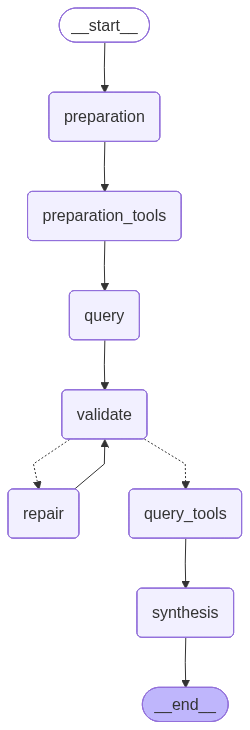

In [58]:
from langgraph.graph import StateGraph, END

graph = StateGraph(AgentState)

graph.add_node("preparation", preparation_node)
graph.add_node("preparation_tools", tool_execution_node)
graph.add_node("query", query_node)
graph.add_node("validate", validation_node)
graph.add_node("repair", repair_node)
graph.add_node("query_tools", query_execution_node)
graph.add_node("synthesis", synthesis_node)

graph.set_entry_point("preparation")
graph.add_edge("preparation", "preparation_tools")
graph.add_edge("preparation_tools", "query")
graph.add_edge("query", "validate")

def validation_router(state: AgentState):
    if state.get("validation_errors"):
        return "repair"
    return "query_tools"

graph.add_conditional_edges(
    "validate",
    validation_router,
    {
        "repair": "repair",
        "query_tools": "query_tools",
    }
)

graph.add_edge("repair", "validate")
graph.add_edge("query_tools", "synthesis")

agent = graph.compile()
agent


C'est une structure plus complexe ! Et a priori plus robuste sur l'appel à l'API. Mais puisque l'agent met du temps à répondre, nous souhaiterions être certain qu'il est parti sur la bonne piste.

## *Human in the loop*

Il est temps d'intégrer l'humain dans le processus pour valider ou non que le plan identifié est correct. Si ce n'est pas le cas, alors l'humain peut modifier le pla voire préciser sa question.

Pour démarrer, nous devons à nouveau modifier la classe de l'agent.

**Consigne** : Ajouter un dictionnaire optionnel nommé *human_feedback*.

In [69]:
class AgentState(TypedDict):
    question: str
    tool_thoughts: str
    tool_calls: List[dict]
    tool_results: List[Any]

    query_thoughts: str
    query_plan: Optional[dict]
    validation_errors: Optional[List[str]]

    human_feedback: Optional[dict]

    query_results: Optional[List[dict]]
    answer: str


On continue avec le noeud concernant l'appel à l'humain. On se propose trois possibilitées :
1. **Approuver** : on continue avec ce plan
2. **Editer** : on modifie le plan qui est proposé par l'agent, puis on repart sur le module de validation
3. **Rejeter** : on reformule la question que l'on a posé, puis on repart sur l'étape de préparation

Pour éviter le cas où l'on édite le plan, qu'il est valider par le module de validation et qu'on nous re-sollicite, on ajoute une vérification que l'humain n'a pas déjà été sollicité.

In [70]:
def human_approval_node(state: AgentState) -> AgentState:
    if state.get("human_feedback"):
        return state
    else:
        plan = state["query_plan"]

        print("\nProposed query plan:")
        print(f"Indicator: {plan['indicator_code']}")
        print(f"Countries: {', '.join(plan['countries'])}")
        print(f"Years: {plan['start_year']}–{plan['end_year']}")

        decision = input("\nApprove? (y = yes / e = edit / n = reject): ").strip().lower()

        if decision == "y":
            state["human_feedback"] = {"approved": True}

        elif decision == "e":
            edited = input("\nEnter corrected query plan as JSON:\n")
            state["human_feedback"] = {"approved": False, "edited_plan": edited}

        else:
            new_q = input("\nPlease rephrase your question:\n")
            state["human_feedback"] = {"approved": False, "new_question": new_q}

        return state


Et on obtient alors un nouveau graphe :

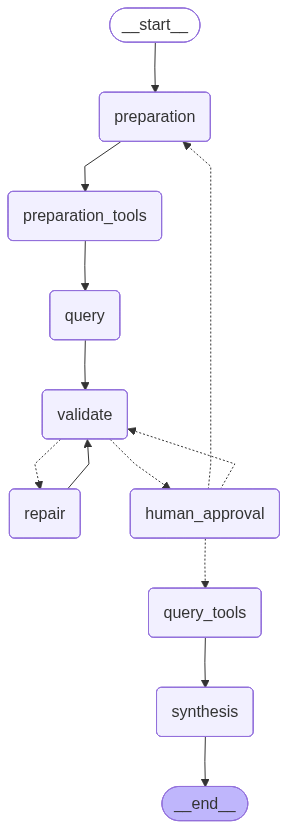

In [71]:
from langgraph.graph import StateGraph, END

graph = StateGraph(AgentState)

graph.add_node("preparation", preparation_node)
graph.add_node("preparation_tools", tool_execution_node)
graph.add_node("query", query_node)
graph.add_node("validate", validation_node)
graph.add_node("repair", repair_node)

graph.add_node("human_approval", human_approval_node)

graph.add_node("query_tools", query_execution_node)
graph.add_node("synthesis", synthesis_node)

graph.set_entry_point("preparation")
graph.add_edge("preparation", "preparation_tools")
graph.add_edge("preparation_tools", "query")
graph.add_edge("query", "validate")

def validation_router(state: AgentState):
    return "repair" if state.get("validation_errors") else "human_approval"

graph.add_conditional_edges(
    "validate",
    validation_router,
    {
        "repair": "repair",
        "human_approval": "human_approval",
    }
)

graph.add_edge("repair", "validate")

def approval_router(state: AgentState):
    fb = state["human_feedback"]

    if fb.get("approved"):
        return "query_tools"
    elif "edited_plan" in fb:
        return "validate"
    elif "new_question" in fb:
        return "preparation"
    else:
        return "preparation"


graph.add_conditional_edges(
    "human_approval",
    approval_router,
    {
        "query_tools": "query_tools",
        "validate": "validate",
        "preparation": "preparation",
    }
)


graph.add_edge("query_tools", "synthesis")

agent = graph.compile()
agent

In [72]:
question = "What the evolution of France's inflation between 2015 and 2025 ? Comment on this value using the inflation in Europe, or in Germany for example."

initial_state = {
    "question": question,

    "tool_thoughts": "",
    "tool_calls": [],
    "tool_results": [],

    "query_thoughts": "",
    "query_plan": {},
    "validation_errors": [],

    "human_feedback": {},

    "query_results": [],
    "answer": ""
}

result = agent.invoke(initial_state)


Proposed query plan:
Indicator: FP.CPI.TOTL.ZG
Countries: FRA, DEU, EUU
Years: 2015–2025


/var/folders/lf/gcppmty149qbrnk_k09vzs040000gn/T/ipykernel_70344/3418753536.py:29: PydanticDeprecatedSince20: The `dict` method is deprecated; use `model_dump` instead. Deprecated in Pydantic V2.0 to be removed in V3.0. See Pydantic V2 Migration Guide at https://errors.pydantic.dev/2.11/migration/
  state["query_plan"] = plan.dict()


Query API : FP.CPI.TOTL.ZG	['2015', '2025']	['FRA', 'DEU', 'EUU']


In [74]:
print(result["answer"])

Here's the evolution of France's inflation between 2015 and 2025, based on World Bank data, and a comparison with Europe (specifically the European Union) and Germany:

**France's Inflation (2015-2024):**

*   **2015:** -0.06% (deflation)
*   **2016:** 0.18%
*   **2017:** 1.43%
*   **2018:** 1.74%
*   **2019:** 1.63%
*   **2020:** 0.48%
*   **2021:** 2.55%
*   **2022:** 5.22% (a significant spike)
*   **2023:** 4.88%
*   **2024:** 2.00%

**Comparison:**

*   **European Union (EU):** Inflation in the EU generally followed a similar trend, with a noticeable spike in 2022 (8.83%) and 2023 (6.30%). In 2024, the inflation was 2.44%.
*   **Germany:** Germany's inflation was often higher than both France and the EU average, particularly in 2022 (6.87%) and 2023 (5.95%). In 2024, Germany's inflation was 2.26%.

Overall, France experienced relatively low inflation prior to 2021, followed by a sharp increase in 2022, and a decrease in 2024, with values close to Germany and the European Union.
